# Training of segmentation algorithm GCN

In [1]:
1+1

2

In [26]:
import os.path as osp
from m2nist_superpixels import M2NISTSuperpixels
from torch_geometric.data import DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import MNISTSuperpixels
import torch_geometric.transforms as T
from torch_geometric.data import DataLoader
from torch_geometric.utils import normalized_cut
from torch_geometric.nn import (NNConv, graclus, max_pool, max_pool_x,
                                global_mean_pool)

import matplotlib.pyplot as plt
import numpy as np
__file__ = osp.abspath('')



In [13]:
## setting datasets

In [14]:
path = osp.join(osp.dirname(osp.realpath(__file__)), 'data', 'M2NIST')
print(path)
train_dataset = M2NISTSuperpixels(path, True, transform=T.Cartesian())
test_dataset = M2NISTSuperpixels(path, False, transform=T.Cartesian()) 
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
d = train_dataset


/home/ari/gcn_segmentation/data/M2NIST
Processing...
Done!


In [15]:
print(d[0])


Data(edge_attr=[245, 2], edge_index=[2, 245], pos=[75, 2], x=[75, 1], y=[1])


Data(edge_attr=[245, 2], edge_index=[2, 245], pos=[75, 2], x=[75, 1], y=[1])


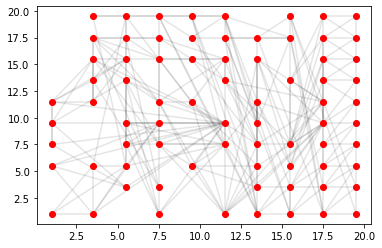

In [16]:
print(d[0])
pos_x = d[0].pos[:,0].numpy()
pos_y = d[0].pos[:,1].numpy()
coo_matrix = d[0].edge_index 

for i in range(d[0].num_edges):
    ii, jj = coo_matrix[0,i], coo_matrix[1,i]
    plt.plot([pos_x[ii],pos_x[jj]],[pos_y[ii],pos_y[jj]],'k-',alpha=0.1)
plt.plot(pos_x, pos_y, 'ro')

In [17]:
d[0].num_edges

245

In [18]:
def normalized_cut_2d(edge_index, pos):
    row, col = edge_index
    edge_attr = torch.norm(pos[row] - pos[col], p=2, dim=1)
    return normalized_cut(edge_index, edge_attr, num_nodes=pos.size(0))


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        nn1 = nn.Sequential(nn.Linear(2, 25), nn.ReLU(), nn.Linear(25, 32))
        self.conv1 = NNConv(d.num_features, 32, nn1, aggr='mean')

        nn2 = nn.Sequential(nn.Linear(2, 25), nn.ReLU(), nn.Linear(25, 2048))
        self.conv2 = NNConv(32, 64, nn2, aggr='mean')

        self.fc1 = torch.nn.Linear(64, 128)
        self.fc2 = torch.nn.Linear(128, d.num_classes)

    def forward(self, data):
        data.x = F.elu(self.conv1(data.x, data.edge_index, data.edge_attr))
        weight = normalized_cut_2d(data.edge_index, data.pos)
        cluster = graclus(data.edge_index, weight, data.x.size(0))
        data = max_pool(cluster, data, transform=T.Cartesian(cat=False))

        data.x = F.elu(self.conv2(data.x, data.edge_index, data.edge_attr))
        weight = normalized_cut_2d(data.edge_index, data.pos)
        cluster = graclus(data.edge_index, weight, data.x.size(0))
        x, batch = max_pool_x(cluster, data.x, data.batch)

        x = global_mean_pool(x, batch)
        x = F.elu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        return F.log_softmax(self.fc2(x), dim=1)

In [19]:
## NETWORK instances
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [20]:
## Training and testing...
def train(epoch):
    model.train()

    if epoch == 16:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.001

    if epoch == 26:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.0001

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        F.nll_loss(model(data), data.y).backward()
        optimizer.step()


def test():
    model.eval()
    correct = 0

    for data in test_loader:
        data = data.to(device)
        pred = model(data).max(1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(test_dataset)

In [21]:
# training
for epoch in range(1, 31):
    train(epoch)
    test_acc = test()
    print('Epoch: {:02d}, Test: {:.4f}'.format(epoch, test_acc))

Epoch: 01, Test: 0.9526
Epoch: 02, Test: 0.9462
Epoch: 03, Test: 0.9564
Epoch: 04, Test: 0.9559
Epoch: 05, Test: 0.9502
Epoch: 06, Test: 0.9454
Epoch: 07, Test: 0.9458
Epoch: 08, Test: 0.9570


KeyboardInterrupt: 

In [22]:
torch.save(model.state_dict(), path+'/overfit.pth')

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net()
model.load_state_dict(torch.load(path+'/overfit.pth'))
model.to(device)
model.eval()
validation_loader = DataLoader(test_dataset, batch_size=64*84, shuffle=False)


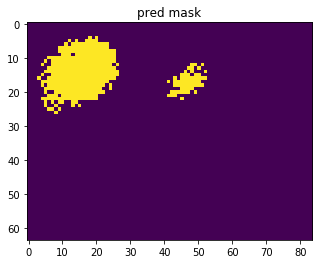

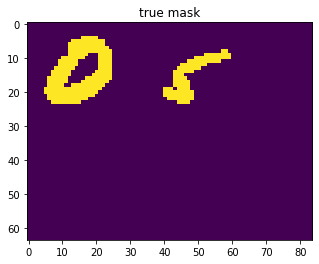

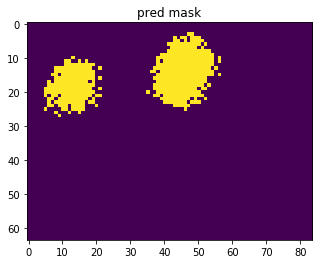

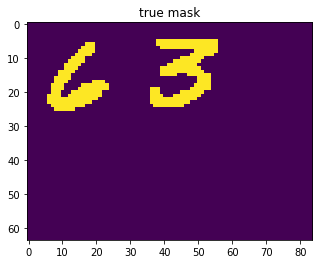

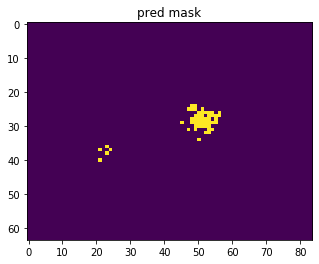

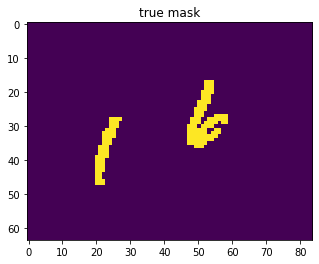

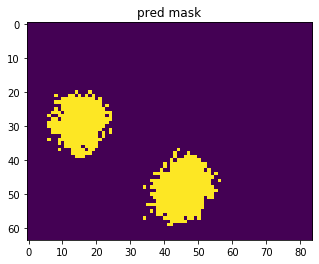

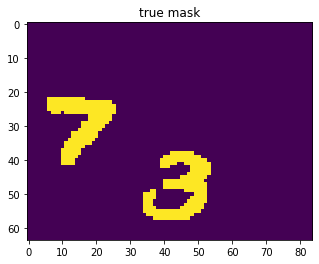

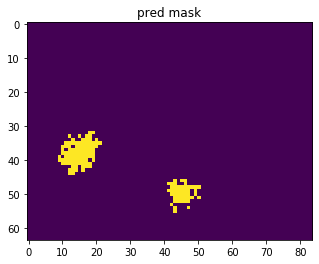

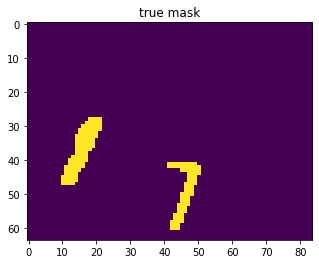

In [29]:
for data in validation_loader:
    data = data.to(device)
    pred = model(data).max(1)[1]
    image_pred = pred.numpy().reshape(64,84)
    image_real = data.y.numpy().reshape(64,84)
    plt.figure()
    plt.imshow(image_pred)
    plt.title('pred mask')
    plt.figure()
    plt.imshow(image_real)
    plt.title('true mask')

In [27]:
a = np.array([[1,2,3],[4,5,6]])
b=a.flatten()
b.reshape(2,3)

array([[1, 2, 3],
       [4, 5, 6]])